# 이미지 생성/편집 서비스 테스트

`app` 폴더 내부의 이미지 생성 로직을 테스트합니다.

**테스트 흐름** (reference/main.py의 메시지 흐름 기반):
1. 새 캐릭터 이미지 생성 (베이스)
2. 특정 부위 수정 (장발 + 흉터)
3. 시간 흐름 반영 (10년 후)

**테스트 대상 서비스:**
- `PromptService`: Claude를 이용한 프롬프트 최적화
- `BedrockService`: Nova Canvas 및 Stability AI 이미지 생성/편집
- `ImageService` (LangGraph): 전체 워크플로우 오케스트레이션

> ⚠️ **S3 업로드 비활성화**: 테스트 중에는 S3 업로드를 건너뛰고 로컬 파일로 저장합니다.

## 1. 환경 설정

In [1]:
import os
import sys
from pathlib import Path

# 프로젝트 루트를 sys.path에 추가
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

print(f"프로젝트 루트: {PROJECT_ROOT}")

프로젝트 루트: c:\jungle\weapon\sto-link-image-backend


In [2]:
# .env 파일 로드
from dotenv import load_dotenv

env_path = PROJECT_ROOT / '.env'
load_dotenv(env_path)

# 환경 변수 확인
print("환경 변수 확인:")
print(f"  AWS_ACCESS_KEY_ID: {'설정됨' if os.getenv('AWS_ACCESS_KEY_ID') else '❌ 미설정'}")
print(f"  AWS_SECRET_ACCESS_KEY: {'설정됨' if os.getenv('AWS_SECRET_ACCESS_KEY') else '❌ 미설정'}")
print(f"  AWS_REGION: {os.getenv('AWS_REGION', '❌ 미설정')}")

환경 변수 확인:
  AWS_ACCESS_KEY_ID: 설정됨
  AWS_SECRET_ACCESS_KEY: 설정됨
  AWS_REGION: us-east-1


In [3]:
# 테스트용 이미지 저장 폴더
TEST_IMAGES_FOLDER = Path.cwd() / "generated_images"
TEST_IMAGES_FOLDER.mkdir(exist_ok=True)
print(f"\n이미지 저장 폴더: {TEST_IMAGES_FOLDER}")


이미지 저장 폴더: c:\jungle\weapon\sto-link-image-backend\test\generated_images


## 2. 서비스 임포트

In [4]:
from app.services.prompt_service import get_prompt_service
from app.services.bedrock_service import get_bedrock_service
from app.services.image_service import get_image_service

print("✅ 서비스 임포트 완료")

✅ 서비스 임포트 완료


## 3. 유틸리티 함수

In [5]:
from datetime import datetime
from IPython.display import Image, display

def save_image_locally(image_bytes: bytes, prefix: str) -> str:
    """이미지 바이트를 로컬 파일로 저장하고 경로 반환"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{prefix}_{timestamp}.png"
    filepath = TEST_IMAGES_FOLDER / filename
    
    with open(filepath, "wb") as f:
        f.write(image_bytes)
    
    print(f"💾 이미지 저장됨: {filepath}")
    return str(filepath)

def show_image(image_path: str, title: str = ""):
    """Jupyter에서 이미지 표시"""
    if title:
        print(f"\n=== {title} ===")
    display(Image(filename=image_path, width=400))

---
## 4. 개별 서비스 테스트

각 서비스를 개별적으로 테스트하여 정상 작동 여부를 확인합니다.

### 4.1 PromptService 테스트 (Claude 프롬프트 생성)

In [6]:
# 프롬프트 서비스 초기화
prompt_service = get_prompt_service()
print("✅ PromptService 초기화 완료")

✅ PromptService 초기화 완료


In [7]:
# 캐릭터 생성용 프롬프트 테스트
test_message = "검은색 정장을 입은 카리스마 있는 20대 한국인 남성"

print(f"입력: {test_message}")
print("\n프롬프트 생성 중...")

enhanced_prompt = prompt_service.create_character_prompt(test_message)

print(f"\n✅ 생성된 프롬프트:")
print(enhanced_prompt)

입력: 검은색 정장을 입은 카리스마 있는 20대 한국인 남성

프롬프트 생성 중...

✅ 생성된 프롬프트:
A professional headshot of a charismatic Korean man in his 20s, wearing a black suit, facing directly at the camera with a confident expression, against a clean white background, high-resolution, sharp details, passport photo style, shoulders and upper body visible, neutral facial expression, professional lighting, studio quality, crisp and clear image, emphasizing facial features


In [8]:
# 이미지 편집용 프롬프트 테스트
edit_request = "기존 인물과 얼굴은 똑같이 유지하되, 머리 길이를 어깨까지 오는 장발로 바꾸고 왼쪽 눈가에 얇은 칼자국 상처를 하나 추가해줘."

print(f"입력: {edit_request}")
print("\n편집 프롬프트 생성 중...")

search_prompt, replace_prompt = prompt_service.create_edit_prompts(edit_request)

print(f"\n✅ 생성된 편집 프롬프트:")
print(f"  Search: {search_prompt}")
print(f"  Replace: {replace_prompt}")

입력: 기존 인물과 얼굴은 똑같이 유지하되, 머리 길이를 어깨까지 오는 장발로 바꾸고 왼쪽 눈가에 얇은 칼자국 상처를 하나 추가해줘.

편집 프롬프트 생성 중...

✅ 생성된 편집 프롬프트:
  Search: short hair
  Replace: long black hair reaching shoulders, styled smoothly


### 4.2 BedrockService 테스트 (이미지 생성)

In [9]:
# Bedrock 서비스 초기화
bedrock_service = get_bedrock_service()
print("✅ BedrockService 초기화 완료")
print(f"  Claude Model: {bedrock_service.claude_model_id}")
print(f"  Nova Canvas: {bedrock_service.nova_canvas_model_id}")
print(f"  Stability Replace: {bedrock_service.stability_replace_model_id}")

✅ BedrockService 초기화 완료
  Claude Model: us.anthropic.claude-3-5-haiku-20241022-v1:0
  Nova Canvas: amazon.nova-canvas-v1:0
  Stability Replace: us.stability.stable-conservative-upscale-v1:0



🎨 Nova Canvas 이미지 생성 중... (30초~1분 소요)
✅ 이미지 생성 완료: 1,547,389 bytes
💾 이미지 저장됨: c:\jungle\weapon\sto-link-image-backend\test\generated_images\base_character_20251227_161416.png

=== 베이스 캐릭터 이미지 ===


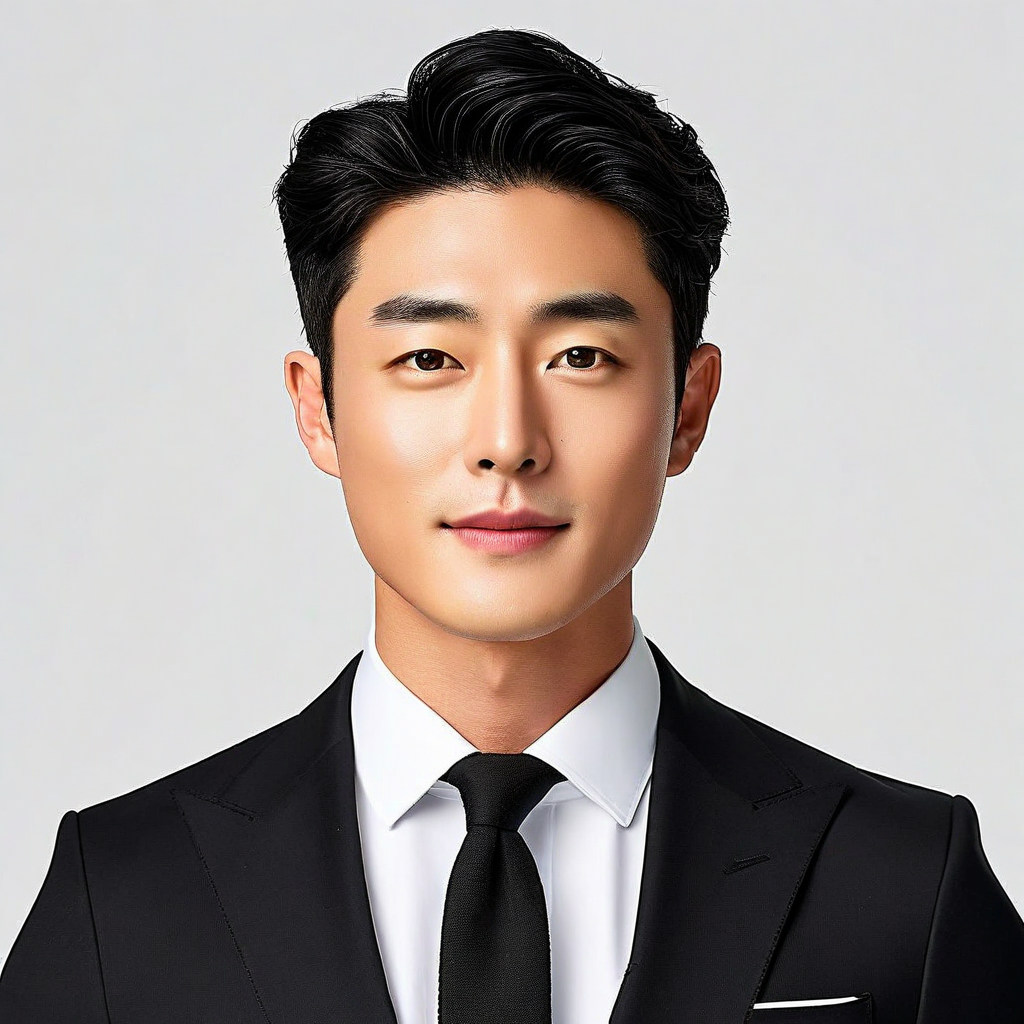

In [10]:
# Nova Canvas로 이미지 생성
print("\n🎨 Nova Canvas 이미지 생성 중... (30초~1분 소요)")

image_bytes = bedrock_service.invoke_nova_canvas(
    prompt=enhanced_prompt,
    negative_prompt="blurry, distorted, low quality, deformed face"
)

print(f"✅ 이미지 생성 완료: {len(image_bytes):,} bytes")

# 로컬에 저장
base_image_path = save_image_locally(image_bytes, "base_character")
show_image(base_image_path, "베이스 캐릭터 이미지")

### 4.3 BedrockService 테스트 (이미지 편집)

In [11]:
# Stability Search & Replace로 이미지 편집
print("\n✏️ Stability AI 이미지 편집 중... (30초~1분 소요)")

# 위에서 생성한 이미지 로드
with open(base_image_path, "rb") as f:
    source_image_bytes = f.read()

edited_bytes = bedrock_service.invoke_stability_search_replace(
    image_bytes=source_image_bytes,
    prompt=replace_prompt,
    search_prompt=search_prompt
)

print(f"✅ 이미지 편집 완료: {len(edited_bytes):,} bytes")

# 로컬에 저장
edited_image_path = save_image_locally(edited_bytes, "edited_feature")
show_image(edited_image_path, "특징 수정 이미지 (장발 + 흉터)")


✏️ Stability AI 이미지 편집 중... (30초~1분 소요)


Stability Search & Replace invocation failed: An error occurred (ValidationException) when calling the InvokeModel operation: {"detail":"Invalid field 'search_prompt' in request. Available fields for upscale-conservative are: image, prompt, negative_prompt, seed, creativity, output_format"}


ValidationException: An error occurred (ValidationException) when calling the InvokeModel operation: {"detail":"Invalid field 'search_prompt' in request. Available fields for upscale-conservative are: image, prompt, negative_prompt, seed, creativity, output_format"}

---
## 5. 전체 워크플로우 테스트 (reference/main.py 흐름)

`ImageService` (LangGraph 기반)를 사용한 전체 테스트입니다.

> ⚠️ **주의**: 이 테스트는 S3 업로드를 포함합니다. S3를 비활성화하려면 아래 셀의 주석을 참고하세요.

In [ ]:
# ============================================================
# S3 업로드를 건너뛰고 로컬 저장만 하려면 아래 코드 실행
# ============================================================

# 임시로 S3 업로드 노드를 패치하여 로컬 저장으로 대체
from unittest.mock import patch

_generated_images = {}  # 테스트 중 생성된 이미지 저장

def mock_upload_to_s3_node(state):
    """S3 업로드 대신 로컬 저장"""
    if state.get("error") or not state.get("generated_image_bytes"):
        return state
    
    prefix = "character" if state["action"] == "create" else "edited"
    filepath = save_image_locally(state["generated_image_bytes"], prefix)
    
    # 전역 변수에도 저장
    _generated_images[prefix] = filepath
    
    # 로컬 파일 경로를 URL 대신 반환
    return {**state, "result_image_url": f"file://{filepath}"}

print("✅ S3 업로드 모킹 준비 완료")
print("   (아래 테스트는 S3 대신 로컬에 저장됩니다)")

### 5.1 Step 1: 새 캐릭터 이미지 생성

In [ ]:
print("="*50)
print("1. [신규 생성] 캐릭터 베이스 이미지 생성 중...")
print("="*50)

base_user_msg = "검은색 정장을 입은 카리스마 있는 20대 한국인 남성"
print(f"\n입력 메시지: {base_user_msg}")

# S3 업로드를 로컬 저장으로 패치
with patch('app.graph.image_graph.upload_to_s3_node', mock_upload_to_s3_node):
    # 그래프 재빌드 (패치 적용)
    from app.graph.image_graph import build_image_graph
    patched_graph = build_image_graph()
    
    # 상태 초기화
    initial_state = {
        "action": "create",
        "message": base_user_msg,
        "source_image_url": None,
        "enhanced_prompt": None,
        "search_prompt": None,
        "replace_prompt": None,
        "generated_image_bytes": None,
        "result_image_url": None,
        "error": None,
        "job_id": "test-job-001",
        "character_id": "test-char-001",
    }
    
    result = patched_graph.invoke(initial_state)

if result.get("error"):
    print(f"\n❌ 오류 발생: {result['error']}")
else:
    print(f"\n✅ 베이스 이미지 생성 완료")
    print(f"   Enhanced Prompt: {result['enhanced_prompt'][:100]}...")
    base_result_path = result['result_image_url'].replace('file://', '')
    show_image(base_result_path, "베이스 이미지")

### 5.2 Step 2: 특정 부위 수정 (장발 + 흉터)

In [ ]:
print("="*50)
print("2. [부분 수정] 장발로 변경 및 왼쪽 눈가에 흉터 추가 중...")
print("="*50)

edit_feature_msg = "기존 인물과 얼굴은 똑같이 유지하되, 머리 길이를 어깨까지 오는 장발로 바꾸고 왼쪽 눈가에 얇은 칼자국 상처를 하나 추가해줘."
print(f"\n편집 요청: {edit_feature_msg}")

# 이전 단계에서 생성된 이미지 경로 사용 (로컬 파일)
# 편집 테스트에서는 로컬 파일을 직접 읽어서 처리

# 편집 프롬프트 생성
search_prompt_2, replace_prompt_2 = prompt_service.create_edit_prompts(edit_feature_msg)
print(f"\n생성된 프롬프트:")
print(f"  Search: {search_prompt_2}")
print(f"  Replace: {replace_prompt_2}")

# 이미지 편집
with open(base_result_path, "rb") as f:
    source_bytes_2 = f.read()

print("\n✏️ 이미지 편집 중... (30초~1분 소요)")
edited_bytes_2 = bedrock_service.invoke_stability_search_replace(
    image_bytes=source_bytes_2,
    prompt=replace_prompt_2,
    search_prompt=search_prompt_2
)

feature_edited_path = save_image_locally(edited_bytes_2, "edited_feature")
show_image(feature_edited_path, "특징 수정 이미지 (장발 + 흉터)")

### 5.3 Step 3: 시간 흐름 반영 (10년 후)

In [ ]:
print("="*50)
print("3. [시간 흐름] 캐릭터의 10년 후 모습 생성 중...")
print("="*50)

age_edit_msg = "이 인물이 10년 후 모습을 보여줘"
print(f"\n편집 요청: {age_edit_msg}")

# 베이스 이미지 기준으로 10년 후 (더 일관된 결과)
search_prompt_3, replace_prompt_3 = prompt_service.create_edit_prompts(age_edit_msg)
print(f"\n생성된 프롬프트:")
print(f"  Search: {search_prompt_3}")
print(f"  Replace: {replace_prompt_3}")

# 이미지 편집
with open(base_result_path, "rb") as f:
    source_bytes_3 = f.read()

print("\n✏️ 이미지 편집 중... (30초~1분 소요)")
edited_bytes_3 = bedrock_service.invoke_stability_search_replace(
    image_bytes=source_bytes_3,
    prompt=replace_prompt_3,
    search_prompt=search_prompt_3
)

aged_image_path = save_image_locally(edited_bytes_3, "edited_aged")
show_image(aged_image_path, "10년 후 이미지")

---
## 6. 결과 요약

In [ ]:
print("=" * 50)
print("전체 테스트 완료!")
print("=" * 50)

print(f"\n📁 이미지 저장 폴더: {TEST_IMAGES_FOLDER}")
print(f"\n✅ 생성된 이미지 파일들:")

try:
    print(f"  1. 베이스 이미지: {base_result_path}")
except NameError:
    print("  1. 베이스 이미지: (미생성)")

try:
    print(f"  2. 특징 수정 이미지: {feature_edited_path}")
except NameError:
    print("  2. 특징 수정 이미지: (미생성)")

try:
    print(f"  3. 10년 후 이미지: {aged_image_path}")
except NameError:
    print("  3. 10년 후 이미지: (미생성)")

## 7. 이미지 비교

In [ ]:
from IPython.display import HTML
import base64

def image_to_base64(path: str) -> str:
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode()

try:
    html = f"""
    <div style="display: flex; justify-content: space-around; gap: 10px; flex-wrap: wrap;">
        <div style="text-align: center;">
            <img src="data:image/png;base64,{image_to_base64(base_result_path)}" style="max-width: 280px;">
            <p><b>1. 베이스 이미지</b></p>
        </div>
        <div style="text-align: center;">
            <img src="data:image/png;base64,{image_to_base64(feature_edited_path)}" style="max-width: 280px;">
            <p><b>2. 특징 수정 (장발+흉터)</b></p>
        </div>
        <div style="text-align: center;">
            <img src="data:image/png;base64,{image_to_base64(aged_image_path)}" style="max-width: 280px;">
            <p><b>3. 10년 후</b></p>
        </div>
    </div>
    """
    display(HTML(html))
except NameError:
    print("⚠️ 이미지 비교를 위해서는 먼저 위의 테스트 셀들을 실행해주세요.")